In [6]:
!pip install scikit-image
!pip install tqdm
!pip install timm

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Obtaining dependency information for scikit-image from https://files.pythonhosted.org/packages/f1/6c/49f5a0ce8ddcdbdac5ac69c129654938cc6de0a936303caa6cad495ceb2a/scikit_image-0.22.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for networkx>=2.8 from https://files.pythonhosted.org/packages/d5/f0/8fbc882ca80cf077f1b246c0e3c3465f7f415439bdea6b899f6b19f61f70/networkx-3.2.1-py3-none-any.whl.metadata
  Obtaining dependency information for imageio>=2.27 from https://files.pythonhosted.org/packages/fa/04/9abe71dfe8c77f5ee58e8c50df3b562884f7494b56c318b867bd2dcb6ec8/imageio-2.33.0-py3-none-any.whl.metadata
  Obtaining dependency information for tifffile>=2022.8.12 from https://files.pythonhosted.org/packages/f5/72/68ea763b5f3e3d9871492683059ed4724fd700dbe54aa03cdda7a9692129/tifffile-2023.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
import torch

BATCH_SIZE = 32
LR = 0.01
EPOCHS = 100
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
import os
import random
import torch

import pandas as pd
from torch.utils.data import Dataset
from torchvision.io import read_image
from skimage import io

class FishDataset(Dataset):

    df = pd.DataFrame(columns=['anchor', 'positive', 'negative', "a_label", "p_label", "n_label"])

    def __init__(self, image_dirs, transform = None):
        self.transform = transform

        # For each image directory (One dir per class), create a list of tuples (anchor, positive, negative)
        for label, image_dir in enumerate(image_dirs):
            image_paths = os.listdir(image_dir)

            # Ensure that the image_paths are image files .jpg or .png
            image_paths = [path for path in image_paths if path.endswith('.jpg') or path.endswith('.png')]
            
 
            for anchor in image_paths:
               # Select a random positive image
                positive = anchor

                while positive == anchor:
                    positive = random.choice(image_paths)

                # Select a random dir that is not the anchor dir
                neg_idx = random.choice(range(len(image_dirs)))

                while neg_idx == label:
                    neg_idx = random.choice(range(len(image_dirs)))

                negative_dir = image_dirs[neg_idx]

                negative_image_paths = os.listdir(negative_dir)
                negative_image_paths = [path for path in negative_image_paths if path.endswith('.jpg') or path.endswith('.png')]
                
                # Select a random negative image from the negative dir
                negative = random.choice(negative_image_paths)
                
                # Add the tuple to the dataframe
                self.df = self.df.append({
                    'anchor': os.path.join(image_dir, anchor), 
                    'positive': os.path.join(image_dir, positive),
                    'negative': os.path.join(negative_dir, negative), 
                    "a_label": label, 
                    "p_label": label, 
                    "n_label": neg_idx
                }, ignore_index=True)

        self.df.to_csv("data.csv", index=False)


    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # 
        A_img = io.imread(row['anchor'])
        P_img = io.imread(row['positive'])
        N_img = io.imread(row['negative'])

        A_img = torch.from_numpy(A_img).permute(2,0,1) / 255.0
        P_img = torch.from_numpy(P_img).permute(2,0,1) / 255.0
        N_img = torch.from_numpy(N_img).permute(2,0,1) / 255.0

        if self.transform:
            A_img = self.transform(A_img)
            P_img = self.transform(P_img)
            N_img = self.transform(N_img)

        return A_img, P_img, N_img


In [9]:
from torchvision import transforms

transform = transforms.Resize((256, 256))

# Add all directories up to 18
trainset = FishDataset(image_dirs=["data/train/01", "data/train/02", "data/train/03","data/train/04","data/train/05"], transform=transform)

validset = FishDataset(image_dirs=["data/validate/01", "data/validate/02", "data/validate/03","data/validate/04","data/validate/05"], transform=transform)

print(f"Size of trainset: {len(trainset)}")
print(f"Size of validset: {len(validset)}")

trainset.df.head()

Size of trainset: 10000
Size of validset: 2500


,anchor,positive,negative,a_label,p_label,n_label
0,data/train/01/1_fish_003497135374_10905.png,data/train/01/1_fish_003421145277_23581.png,data/train/05/5_fish_004496547272_25746.png,0,0,4
1,data/train/01/1_fish_000004400001_00182.png,data/train/01/1_fish_004524167333_11013.png,data/train/03/3_fish_004712563565_20799.png,0,0,2
2,data/train/01/1_fish_000175059598_07735.png,data/train/01/1_fish_003433705293_16502.png,data/train/02/2_fish_003399855232_23655.png,0,0,1
3,data/train/01/1_fish_004333867049_11712.png,data/train/01/1_fish_004260126960_27206.png,data/train/02/2_fish_003406055240_23064.png,0,0,1
4,data/train/01/1_fish_004598177455_26547.png,data/train/01/1_fish_003839036184_12963.png,data/train/05/5_fish_004262666961_13595.png,0,0,4


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


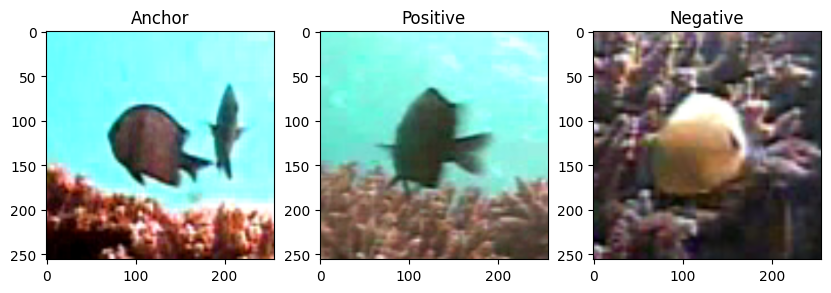

In [10]:
from matplotlib import pyplot as plt

idx = 12

A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,10))

ax1.set_title("Anchor")
ax1.imshow(A.numpy().transpose(1,2,0))

ax2.set_title("Positive")
ax2.imshow(P.numpy().transpose(1,2,0))

ax3.set_title("Negative")
ax3.imshow(N.numpy().transpose(1,2,0))

In [11]:
from torch.utils.data import DataLoader

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

print(f"No. of batches in trainloader: {len(trainloader)}")
print(f"No. of batches in validloader: {len(validloader)}")  

No. of batches in trainloader: 313
No. of batches in validloader: 79


In [12]:
import timm
from torch import nn

class FishModel(nn.Module):

    def __init__(self, emb_size=1024):
        super(FishModel, self).__init__()

        # Use resnet50 as the backbone instead of efficientnet
        self.resnet = timm.create_model('resnet50', pretrained=True)

        self.resnet.fc = nn.Linear(
            in_features=self.resnet.fc.in_features, 
            out_features=emb_size
        )

    def forward(self, x):
        embeddings = self.resnet(x)
        return embeddings

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
from tqdm import tqdm
from torch import optim
from torch import nn
from torch.utils.data import DataLoader

def train(model: nn.Module, dataloader: DataLoader, optimizer: optim.Optimizer, criterion: nn.Module):

    model.train()

    total_loss = 0.0

    for A, P, N in tqdm(dataloader):

        A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

        A_embs = model(A)
        P_embs = model(P)
        N_embs = model(N)

        loss = criterion(A_embs, P_embs, N_embs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


def validate(model: nn.Module, dataloader: DataLoader, criterion: nn.Module):

    model.eval()

    total_loss = 0.0

    with torch.no_grad():
        for A, P, N in tqdm(dataloader):

            A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

            A_embs = model(A)
            P_embs = model(P)
            N_embs = model(N)

            loss = criterion(A_embs, P_embs, N_embs)

            total_loss += loss.item()

    return total_loss / len(dataloader)

In [ ]:
import numpy as np

model = FishModel()
model.to(DEVICE)

criterion = nn.TripletMarginLoss()

optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)

best_valid_loss = np.inf

for epoch in range(EPOCHS):
    
    train_loss = train(model, trainloader, optimizer, criterion)
    valid_loss = validate(model, validloader, criterion)

    torch.save(model.state_dict(), 'models/latest.pt')
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'models/best.pt')

    # Save the loss for every epoch in a file called loss.txt
    with open("loss.txt", "a") as f:
        f.write(f"{train_loss},{valid_loss}\n")
    
    print(f"Epoch: {epoch+1}/{EPOCHS} Train Loss: {train_loss:.4f} Valid Loss: {valid_loss:.4f}")



model.safetensors: 100%|██████████| 102M/102M [00:01<00:00, 102MB/s]  
  0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 79/79 [01:49<00:00,  1.39s/it]


Epoch: 1/100 Train Loss: 0.2844 Valid Loss: 0.1132


100%|██████████| 79/79 [01:44<00:00,  1.32s/it]


Epoch: 2/100 Train Loss: 0.0727 Valid Loss: 0.0924


100%|██████████| 79/79 [01:46<00:00,  1.34s/it]


Epoch: 3/100 Train Loss: 0.0408 Valid Loss: 0.0531


100%|██████████| 79/79 [01:37<00:00,  1.23s/it]


Epoch: 4/100 Train Loss: 0.0248 Valid Loss: 0.0358


100%|██████████| 79/79 [01:40<00:00,  1.27s/it]


Epoch: 5/100 Train Loss: 0.0167 Valid Loss: 0.0396


100%|██████████| 79/79 [01:39<00:00,  1.26s/it]


Epoch: 6/100 Train Loss: 0.0133 Valid Loss: 0.0348


100%|██████████| 79/79 [01:34<00:00,  1.20s/it]


Epoch: 7/100 Train Loss: 0.0093 Valid Loss: 0.0345


100%|██████████| 79/79 [01:32<00:00,  1.17s/it]


Epoch: 8/100 Train Loss: 0.0055 Valid Loss: 0.0310


100%|██████████| 79/79 [01:32<00:00,  1.17s/it]


Epoch: 9/100 Train Loss: 0.0062 Valid Loss: 0.0283


100%|██████████| 79/79 [01:29<00:00,  1.13s/it]


Epoch: 10/100 Train Loss: 0.0028 Valid Loss: 0.0282


100%|██████████| 79/79 [01:32<00:00,  1.17s/it]


Epoch: 11/100 Train Loss: 0.0033 Valid Loss: 0.0295


100%|██████████| 79/79 [01:33<00:00,  1.18s/it]


Epoch: 12/100 Train Loss: 0.0029 Valid Loss: 0.0246


100%|██████████| 79/79 [01:37<00:00,  1.24s/it]


Epoch: 13/100 Train Loss: 0.0032 Valid Loss: 0.0228


100%|██████████| 79/79 [01:30<00:00,  1.14s/it]


Epoch: 14/100 Train Loss: 0.0033 Valid Loss: 0.0223


100%|██████████| 79/79 [01:37<00:00,  1.23s/it]


Epoch: 15/100 Train Loss: 0.0027 Valid Loss: 0.0233


100%|██████████| 79/79 [01:26<00:00,  1.09s/it]


Epoch: 16/100 Train Loss: 0.0021 Valid Loss: 0.0215


100%|██████████| 79/79 [01:31<00:00,  1.16s/it]


Epoch: 17/100 Train Loss: 0.0014 Valid Loss: 0.0217


100%|██████████| 79/79 [01:25<00:00,  1.08s/it]


Epoch: 18/100 Train Loss: 0.0018 Valid Loss: 0.0238


100%|██████████| 79/79 [01:28<00:00,  1.12s/it]


Epoch: 19/100 Train Loss: 0.0009 Valid Loss: 0.0239


100%|██████████| 79/79 [01:27<00:00,  1.10s/it]


Epoch: 20/100 Train Loss: 0.0009 Valid Loss: 0.0253


100%|██████████| 79/79 [01:30<00:00,  1.14s/it]


Epoch: 21/100 Train Loss: 0.0009 Valid Loss: 0.0202


100%|██████████| 79/79 [01:26<00:00,  1.10s/it]


Epoch: 22/100 Train Loss: 0.0007 Valid Loss: 0.0239


100%|██████████| 79/79 [01:33<00:00,  1.19s/it]


Epoch: 23/100 Train Loss: 0.0005 Valid Loss: 0.0246


100%|██████████| 79/79 [01:28<00:00,  1.12s/it]


Epoch: 24/100 Train Loss: 0.0010 Valid Loss: 0.0258


100%|██████████| 79/79 [01:30<00:00,  1.15s/it]


Epoch: 25/100 Train Loss: 0.0010 Valid Loss: 0.0237


100%|██████████| 79/79 [01:34<00:00,  1.19s/it]


Epoch: 26/100 Train Loss: 0.0008 Valid Loss: 0.0264


 52%|█████▏    | 162/313 [03:41<03:27,  1.37s/it]

In [84]:

model = FishModel()
model.load_state_dict(torch.load('best.pt'))

# For each file in the "reference" folder, calculate the embeddings

embeddings = []

for file in os.listdir("references"):
    img = io.imread(os.path.join("references", file))
    img = torch.from_numpy(img).permute(2,0,1) / 255.0
    img = transform(img).unsqueeze(0)

    # Get the embeddings
    emb = model(img)

    embeddings.append(emb.detach().numpy())


# For each file in the "data/test" folder, predict the class
for file in os.listdir("data/test"):
    img = io.imread(os.path.join("data/test", file))
    img = torch.from_numpy(img).permute(2,0,1) / 255.0
    img = transform(img).unsqueeze(0)

    # Get the embeddings
    emb = model(img)

    # Calculate the euclidean distance between the embeddings of the test image and the reference images
    distances = [np.linalg.norm(emb.detach().numpy() - e) for e in embeddings]

    # Get the index of the reference image with the smallest distance
    pred = np.argmin(distances)

    print(f"Predicted class: {pred} Distance: {distances[pred]}")



Predicted class: 0 Distance: 1.2903664112091064
Predicted class: 0 Distance: 1.0943541526794434
Predicted class: 1 Distance: 1.0428030490875244
Predicted class: 0 Distance: 1.1918766498565674
